<a href="https://colab.research.google.com/github/iCaran/catsVdogs/blob/main/Copy_of_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dog vs Cat Image Classifier
---
A CNN model which can tell a dog from a cat with an image prompt.

Uses Keras. Google Colab is used for the GPU provided and the high network bandwidth, as compared to what a personal computer setup can provide.

Dataset used - https://www.kaggle.com/datasets/salader/dogs-vs-cats

The dataset contains two sets of images, one for training and the other for testing the CNN model. Both contain pictures of cats and dogs in their respective folders.

---
To Start off, we create a Kaggle api token and upload the JSON file to our main directory. And then run the following command to create a kaggle directory in our root folder and copy the JSON file into it.

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Then we go to the kaggle page with the dataset mentioned above and copy the API command and paste it as shown below

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats --force

100% 1.06G/1.06G [00:33<00:00, 38.4MB/s]
100% 1.06G/1.06G [00:33<00:00, 34.3MB/s]


The dataset is now downloaded, and stored in the local colab project folder. However, the file downloaded is in zip format, the following code will unzip it using the zipfile module. 

The data is now extracted in the /content folder and is ready to be used.

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Now that the dataset is ready for us, we will use it to train our model. We firstly import all necessary libraries which we will be using -
* Tensorflow
* keras from TF
* Sequential from keras
* a bunch of tools from layers in keras (Dense,Conv2D,MaxPooling2D,Flatten)

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

Now as we begin to train the data, we have to consider our system resources and manage them carefully. Since the dataset has thousands of entries, training the model in one go would overwhelm our RAM and CPU/GPU. So we divide the process into batches.

We use a concept called Generators for this process. Keras provides a generator which we will use called ```image_dataset_from_directory``` In this case, we set the batch size to 32. When a batch finishes processing, then the next batch is processed.

More can be learned here - https://keras.io/api/data_loading/image/

---
We create two instances of ```image_dataset_from_directory```, one for training and one for validation, when testing has completed. 
FOllowing parameters are given for each instance:
* directory - path to relavant datasets. ```/content/train``` for training, and ```/content/test``` for validation respectively.
* labels - inferred
* label_mode - int, we can index our raining/testing classes. In our case, cats will be assigned 0 and dogs will be assigned 1.
* image size - 256,256 - 
The CNN model expects all the images in our dataset to be of same dimensions, but that is not so, therefore we reshape the images to be (256,256,3)

We store the dataset object returned in each case in an aptly named variable.

In [6]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


The images we just successfully ompiled and stored are in the form of a numpy array, in which values range from 0-255. But for our requirements, we have only 2 classes and we need a value range of 0-1.

We therefore use a concept called Normalization.

In the code below, a process function is defined which takes an image and a label, and basically divides the image object by 255 (giving a value between [0,1]) and return back the image and label.

The map function takes one image at a time from train_ds or validation_ds, and send it with its label to the process function. The returned image and label from the process function are stored back into the respective train_ds or validation_ds.

In [7]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

Now that are dataset has been prepared, and our generators have been normalized, we can move on to create our CNN model.

We will crete an architecture with 3 convolution layers. In the first layer there would be 32 filters, 64 filters in the second and 128 in the third layer.

In [8]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

              # neurons
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

Now lets check out the summary of the model we just created.

We can see we have a tensor of (30,30,128), which we flattened, and we are left with close to 14.5 million parameters in our CNN.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

Now we compile and execute our model.

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Let's run it!

We pass our train and validation ds to the ```fit``` function and set the epochs count to 10.

We store the result in a 'history' variable so that we can later plot and see our results.
As we run this, we see that we have 625 batches, since we have a batch size of 32 (625*32=20000, which is the size of our dataset).

If you notice that the training is pretty slow, it's because of our system's processing power. One thing we can do to speed it up, is to use the GPU instead of the CPU. Go to ```Runtime -> Change Runtime type -> Hardware Accelarator -> GPU``` and hit save.

We should now see that the training is a good deal faster. Let's give it some time to complete.

In [11]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 68s 93ms/step - loss: 0.6092 - accuracy: 0.6569 - val_loss: 0.5397 - val_accuracy: 0.7298
Epoch 2/10
625/625 [==============================] - 58s 92ms/step - loss: 0.4823 - accuracy: 0.7667 - val_loss: 0.4830 - val_accuracy: 0.7764
Epoch 3/10
625/625 [==============================] - 58s 93ms/step - loss: 0.3762 - accuracy: 0.8311 - val_loss: 0.5132 - val_accuracy: 0.7934
Epoch 4/10
625/625 [==============================] - 58s 92ms/step - loss: 0.2459 - accuracy: 0.8970 - val_loss: 0.6885 - val_accuracy: 0.7726
Epoch 5/10
625/625 [==============================] - 59s 93ms/step - loss: 0.1381 - accuracy: 0.9460 - val_loss: 0.8874 - val_accuracy: 0.7714
Epoch 6/10
625/625 [==============================] - 58s 92ms/step - loss: 0.0826 - accuracy: 0.9712 - val_loss: 1.0508 - val_accuracy: 0.7700
Epoch 7/10
625/625 [==============================] - 58s 92ms/step - loss: 0.0675 - accuracy: 0.9785 - val_loss: 1.1201 - val_accuracy:

Now that all our 10 epochs have finished training, let's plot see our results. 
We plot the graphs of training and validation accuracy.

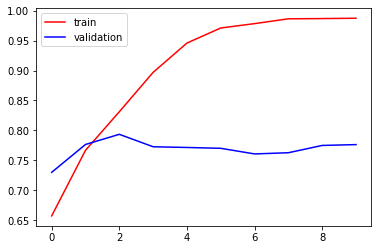

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

We can see that as we perfom more and more epochs, the training accuracy increases. But we see that our validation accuracy fluctuates between 75 and 80, and this gap between the train and validation tells us that overfitting is taking place.


Just to conclude, we also plot validation loss and training loss. We see that as we perform more epochs, training loss reduces, but validation loss keeps rising. A clear indication that ***overfitting*** occurs.

This means that our model gives good results over our training data, but not over test data.

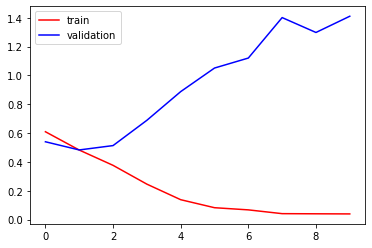

In [13]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

We need to fix this, now there are several ways to do this:

# ways to reduce overfitting

* Add more data - Give your model more data to train over, which is not really possible for us, since we have exhausted our dataset.
* Data Augmentation -> This is process to create more data from our existing data.
* L1/L2 Regularizer
* Dropout
* Batch Normalization
* Reduce complexity
---

Let's try to reduce the overfitting in our data through Batch Normalization and Dropout

To do this, let's first import BatchNormalization and Dropout

In [14]:
from keras.layers import BatchNormalization, Dropout

Now let's create our model again, this time we add BatchNormalization and Dropout to it.

BatchNormalization also improves our training, if you want you could try out higher learning rate.

In [15]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

Let's run through our model once again.

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 74s 117ms/step - loss: 1.3491 - accuracy: 0.5870 - val_loss: 0.6725 - val_accuracy: 0.6348
Epoch 2/10
625/625 [==============================] - 74s 118ms/step - loss: 0.6009 - accuracy: 0.6894 - val_loss: 0.5767 - val_accuracy: 0.7108
Epoch 3/10
625/625 [==============================] - 72s 115ms/step - loss: 0.5018 - accuracy: 0.7552 - val_loss: 0.4627 - val_accuracy: 0.7762
Epoch 4/10
625/625 [==============================] - 72s 115ms/step - loss: 0.4289 - accuracy: 0.8016 - val_loss: 0.5000 - val_accuracy: 0.7600
Epoch 5/10
625/625 [==============================] - 72s 114ms/step - loss: 0.3629 - accuracy: 0.8370 - val_loss: 0.4833 - val_accuracy: 0.7874
Epoch 6/10
625/625 [==============================] - 72s 115ms/step - loss: 0.2958 - accuracy: 0.8719 - val_loss: 0.4284 - val_accuracy: 0.8070
Epoch 7/10
625/625 [==============================] - 72s 114ms/step - loss: 0.2257 - accuracy: 0.9043 - val_loss: 0.5568 - val_ac

Now as you can see, the accuracy has improved a bit, we have reached 80%. Now if we plot our graphs again, we can see the difference on comparison. The gap between train and validation has reduced somewhat.

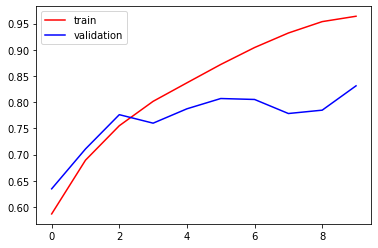

In [18]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

Same is the case for the Loss graph. The gap has narrowed again.

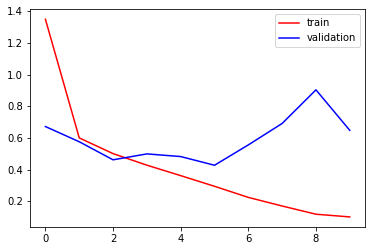

In [19]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Now it's time to test how well our model performs, let's get it some data to predict over.

We download random image of a dog and a cat to test over and add it to our project's directory. We import OpenCV and use it to parse our image so we can feed it to the model. 

In [20]:
import cv2

```test_img``` contains a numpy array, created from the image we just passed to it.

In [21]:
test_img = cv2.imread('/content/cat.jpg')

We can plot and see our image. The image's colour (RGB) is not preserved when we import it through OpenCV, as can be seen.

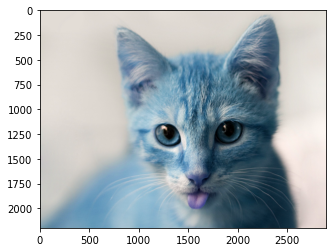

In [22]:
plt.imshow(test_img)

We can also see that the shape our image does not match the standard dimensions we used in our model, so we need to resize it.

In [23]:
test_img.shape

(2196, 2891, 3)

We resize our image into (256,256,3)

In [24]:
test_img = cv2.resize(test_img,(256,256))

Now, we know that we pass images to our model in batches. Since we only have one image, so our batch will contain only one image. We convert it to a 4D tensor - (1,256,256,3).

This means that our batch contains 1 image, with the dimensions of (256,256,3). We store it in test_input.

In [25]:
test_input = test_img.reshape((1,256,256,3))

Now as we pass our ```test_input``` to the predict function, we get an output of 0, which means the model has identified the object in the image as a cat, since cat was assigned 0 and dog was assigned 1 through the order of our dataset when we trained our model.

In [26]:
model.predict(test_input)

1/1 [==============================] - 0s 246ms/step


array([[0.]], dtype=float32)

We can see that even when our accuracy right now is only 80-81%, it performs decently over new data.

Now let's try it out with the image of a dog.

In [32]:
test_img = cv2.imread('/content/dog.jpg')

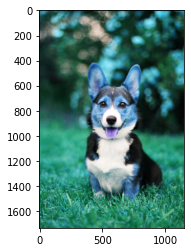

In [33]:
plt.imshow(test_img)

In [34]:
test_img = cv2.resize(test_img,(256,256))

In [35]:
test_input = test_img.reshape((1,256,256,3))

In [36]:
model.predict(test_input)

1/1 [==============================] - 0s 17ms/step


array([[1.]], dtype=float32)

We get the correct output on 1, showing that the prediction is that the image contains a dog.